In [8]:
#pip install transformers datasets evaluate accelerate pillow torchvision scikit-learn

In [6]:
from huggingface_hub import notebook_login

notebook_login()


## 1. Load Dataset

In [10]:
#split="train": By specifying just "train", you are indicating that you want to load the entire training set without any slicing.

from datasets import load_dataset

dataset = load_dataset('FastJobs/Visual_Emotional_Analysis', split="train")
dataset


Resolving data files:   0%|          | 0/800 [00:00<?, ?it/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 800
})

In [11]:
dataset = dataset.train_test_split(test_size=0.2)

In [12]:
dataset["train"][0]


{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=96x96>,
 'label': 3}

In [13]:
# dictionary that maps the label name to an integer and vice versa
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [14]:
id2label[str(1)]

'contempt'

## 2. Preprocess

In [15]:
#The next step is to load a ViT image processor to process the image into a tensor:

from transformers import AutoImageProcessor

checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [16]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

In [17]:
#create a preprocessing function to apply the transforms and return the pixel_values - the inputs to the model - of the image

def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [18]:
#To apply the preprocessing function over the entire dataset, use 🤗 Datasets with_transform method
dataset = dataset.with_transform(transforms)

In [19]:
#Now create a batch of examples using DefaultDataCollator. Unlike other data collators in 🤗 Transformers, the DefaultDataCollator does not apply additional preprocessing such as padding
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

## 3. Evaluate

In [20]:
#Including a metric during training is often helpful for evaluating your model’s performance. You can quickly load an evaluation method with the 🤗 Evaluate library.
import numpy as np
import evaluate

# Load the accuracy metric
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    # Calculate accuracy using the evaluate library
    return accuracy.compute(predictions=predictions, references=labels)


## 4. Train

In [21]:
#Load ViT with AutoModelForImageClassification. Specify the number of labels along with the number of expected labels, and the label mappings:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:

from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="my_awesome_emotion_identifier_model",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)



In [30]:

import torch
import os

# Define the directory and file path
output_dir = "my_awesome_food_model"
test_path = os.path.join(output_dir, "test_checkpoint.pth")

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Define the object to save
test_obj = {"test": "data"}

# Save the object
torch.save(test_obj, test_path)
print("Test checkpoint saved successfully.")



Test checkpoint saved successfully.


In [31]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.990000,1.972334,0.225000
2,1.894200,1.876151,0.381250
3,1.803600,1.822451,0.387500


TrainOutput(global_step=30, training_loss=1.8959239323933919, metrics={'train_runtime': 5751.6529, 'train_samples_per_second': 0.334, 'train_steps_per_second': 0.005, 'total_flos': 1.4879262111694848e+17, 'train_loss': 1.8959239323933919, 'epoch': 3.0})

In [32]:
#share your model to the hub so that it can be used by everyone 
trainer.push_to_hub()

CommitInfo(commit_url='https://huggingface.co/Deepri24/my_awesome_emotion_identifier_model/commit/f6367dacf99f72a1291cca8613769d2cad6005cd', commit_message='End of training', commit_description='', oid='f6367dacf99f72a1291cca8613769d2cad6005cd', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Deepri24/my_awesome_emotion_identifier_model', endpoint='https://huggingface.co', repo_type='model', repo_id='Deepri24/my_awesome_emotion_identifier_model'), pr_revision=None, pr_num=None)

#### Congratulations! You have fine-tuned your model and shared it on the 🤗 Hub. You can now use it for inference!

## 5. Inference 

Resolving data files:   0%|          | 0/800 [00:00<?, ?it/s]

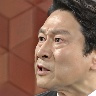

In [51]:
#Load an image you’d like to run inference on:

#loading the validation split of the dataset but only the first 10 samples.
ds = load_dataset('FastJobs/Visual_Emotional_Analysis', split="train[:10]")

#ds["image"]: In a dictionary-like structure, you can access data by specifying the key, which is the column name, image here
#[0]: selects the first image from loaded 10 samples of subset
image = ds["image"][9]
display(image)

#### Two ways to run inference - via pipeline or Pytorch/Tensorflow



In [52]:
# a) Simplest way to try out finetuned modelis to use it in a pipeline(). Instantiate a pipeline for task and the model, and pass your image to it:

from transformers import pipeline

classifier = pipeline("image-classification", model="my_awesome_emotion_identifier_model")
classifier(image)


[{'label': 'anger', 'score': 0.583796501159668},
 {'label': 'sad', 'score': 0.5656100511550903},
 {'label': 'disgust', 'score': 0.519493579864502},
 {'label': 'fear', 'score': 0.49906107783317566},
 {'label': 'surprise', 'score': 0.4989865720272064}]

##### Pytorch Method

In [53]:
# b) Or you can also manually replicate the results of the pipeline using Pytorch/Tensorflow, I am using Pytorch here:
#Load an image processor to preprocess the image and return the input as PyTorch tensors:

from transformers import AutoImageProcessor
import torch

image_processor = AutoImageProcessor.from_pretrained("my_awesome_emotion_identifier_model")
inputs = image_processor(image, return_tensors="pt")



In [54]:
#Pass your inputs to the model and return the logits:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained("my_awesome_emotion_identifier_model")
with torch.no_grad(): #prevent PyTorch from tracking gradients, which is not needed during inference/ prediction to save memory/computation
    logits = model(**inputs).logits

#logits are the unnormalized output scores of the model, representing the model's confidence for each class before converting them to probabilities. They serve as the basis for determining the predicted class for a given input.


In [55]:
#Get the predicted label with the highest probability, and use the model’s id2label mapping to convert it to a label:
predicted_label = logits.argmax(-1).item()
model.config.id2label[predicted_label]

#The code effectively determines which class the model predicts for a given input by:
# - Finding the index of the class with the highest logit score (the most confident prediction).
#- Using that index to look up the corresponding class label from a predefined mapping

'anger'